In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from eegatscale.models import LinearHeadBENDR
from eegatscale.transforms import Standardize
from scipy.stats import ttest_ind
import torch
import tqdm

from captum.concept import TCAV, Concept
from captum.concept._utils.common import concepts_to_str
from concept_classifier import TCAVClassifier
import warnings
warnings.filterwarnings("ignore")

from dataset_utils import Experiment

In [2]:
concepts_dir = '/scratch/s194101/concepts/'

print(list(os.listdir(concepts_dir)))



['random_mmidb_alpha_no_baseline_lh', 'random_tuh_alpha', 'sanity_check_concepts_MMIDB_alpha_no_baseline', 'random_mmidb_gamma_no_baseline_rh', 'random_mmidb_alpha_lh', 'random_right_concept_MMIDB_Alpha_sanity_check', 'TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124', 'random_mmidb_alpha_rh', 'random_right_concept_MMIDB_Alpha_sanity_check_1000', 'TUSZ', 'random_mmidb_gamma_no_baseline_lh', 'random_tuh_alpha_1000', 'random_mmidb_alpha_no_baseline_rh', 'sanity_check_concepts_MMIDB_all_no_baseline', 'TUEV', 'sanity_check_concepts_MMIDB_all_baseline', 'random_mmidb_alpha_no_baseline_T0_lh', 'TUH_clean_all_subtract_Truesigma_Trueabs_100.0_135454_131124', 'random_left_concept_MMIDB_Alpha_sanity_check', 'random_left_concept_MMIDB_Alpha_sanity_check_1000', 'random_tuh_all', 'random_tuh_all_1000', 'random_mmidb_alpha_no_baseline_T0_rh']


## Load Seizure model

In [3]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/tusz_noica_noica_60.0_nogroups_2/version_7/checkpoints/epoch=4-step=40.ckpt"

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

Initialized mask embedding and position encoder from  /scratch/s194101/finetune_logs_all/tusz_noica_noica_60.0_nogroups_2/version_7/checkpoints/epoch=4-step=40.ckpt
model loaded


In [18]:
target_data = "TUSZ/seiz"
# target_data = "random_left_concept_MMIDB_Alpha_sanity_check"
random_concept = "TUEV/random"
# random_concept = "random_tuh_alpha"

concept_dir_names = [
    "TUEV/artf",
    "TUEV/bckg",
    "TUEV/gped",
    "TUEV/pled",
    "TUEV/spsw",
    ]
experiments = []
idx = 0
for concept_dir_name in concept_dir_names:
    exp = Experiment(model,
                    target_data,
                    concepts_dir,
                    [
                    concept_dir_name, # this is where you add extra concepts, (in the square brackets)
                    random_concept,
                    ],
                    verbose=True,
                    n_concept_samples=100,
                    n_runs=20,
                    internal_concept_idx=idx)
    experiments.append(exp)
    idx += 1000

Loaded dataset TUEV/artf with 1586 samples
Loaded dataset TUEV/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/bckg with 3209 samples
Loaded dataset TUEV/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/gped with 2343 samples
Loaded dataset TUEV/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/pled with 1976 samples
Loaded dataset TUEV/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples
Loaded dataset TUEV/spsw with 139 samples
Loaded dataset TUEV/random with 200 samples
Loaded input dataset TUSZ/seiz with 370 samples


In [19]:
experiment = experiments[0]
f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"

'/home/s194101/Bachelors-explainability/TUSZ/seiz_artf.pkl'

In [20]:
layers = ["encoder", "enc_augment", "summarizer", "extended_classifier", "clf"]

def run_tcav(experiment:Experiment, layers:list):
    if "/" in experiment.concept_names[0]:
        save_path = f"/scratch/s194101/cav/{experiment.concept_names[0].split('/')[-1]}/"
    else:
        save_path = f"/scratch/s194101/cav/{experiment.concept_names[0]}/"
    tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path=save_path)
    # tcav = TCAV(model, layers, save_path=save_path)
    tcav_scores = tcav.interpret(inputs=experiment.inputs, experimental_sets=experiment.experimental_sets, target=0)
    tcav_scores = dict(tcav_scores)

    save_path = f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(
            {"tcav_scores": tcav_scores,
             "experimental_sets": experiment.experimental_sets,},f)
    return tcav_scores
        

In [21]:
for exp in experiments:
    run_tcav(exp, layers)
    print(exp.inputs_name, exp.concept_names[0])

TUSZ/seiz TUEV/artf
TUSZ/seiz TUEV/bckg
TUSZ/seiz TUEV/gped
TUSZ/seiz TUEV/pled
TUSZ/seiz TUEV/spsw


In [22]:
all_experimental_sets = []
all_tcav_scores = []

for i, exp in enumerate(experiments):
    file_path = f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0].split('/')[-1]}.pkl" if "/" in exp.concept_names[0] else f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0]}.pkl"
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        all_tcav_scores.append(data["tcav_scores"])
        all_experimental_sets.append(data["experimental_sets"])

In [23]:
from plot_utils import assemble_scores, plot_tcav_scores

0.008965372097280712
0.29605635415685766
0.9864514532252983
0.5392532738002964
2.8103122455197163e-15
3.741477520344604e-42
8.182718472248156e-07
0.06121365568557088
0.5392532738002964
0.0
4.589826269195755e-14
0.0007696081483480612
1.2718401269870527e-05
5.887523237377331e-10
5.887520233375287e-10
2.0319908668880506e-17
1.4543113610802443e-10
0.38129203118548627
0.010546953835759385
0.2159578474642721
0.23254130626279204
0.5163822537527065
0.1424427813082415
4.98023503631779e-07
0.5392532738002964


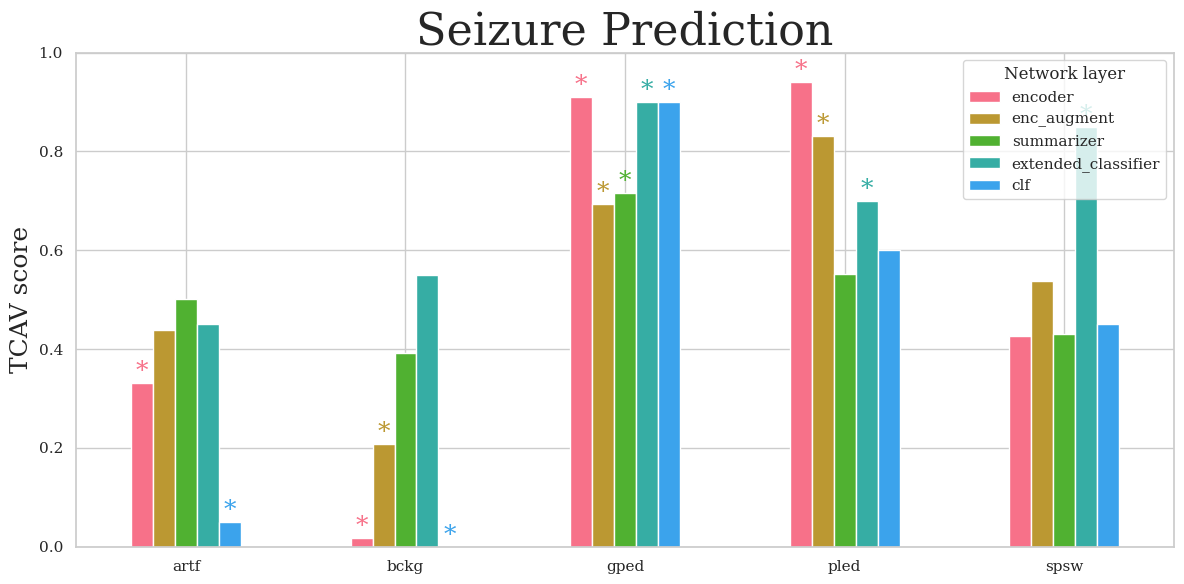

,encoder,enc_augment,summarizer,extended_classifier,clf
artf,0.375940,0.356363,0.360640,0.497494,0.217945
bckg,0.041547,0.305332,0.342719,0.497494,0.000000
gped,0.217804,0.327427,0.265265,0.300000,0.300000
pled,0.182490,0.234456,0.367092,0.458258,0.489898
spsw,0.374733,0.359956,0.285006,0.357071,0.497494


In [24]:
concept_names = ["artf", "bckg", "gped", "pled", "spsw"]
title = "Seizure Prediction"
plt_name = "TUEV_seizure_2"

scores_mean_df, scores_std_df = plot_tcav_scores(all_experimental_sets, all_tcav_scores, concept_names=concept_names, title=title, score_type="sign_count", alpha=0.05, only_significant=False, with_error=False, plt_name=plt_name, file_type="png")
# scores_mean_df
scores_std_df
